In [74]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(color_codes=True)

# Parameter
tau = 60

In [4]:
df = pd.read_csv("/usr/app/data/trippub_2.csv") 
df.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


In [139]:
df.shape

(923572, 115)

In [75]:
# Filter applied
# - TRPTRANS in [03, 04, 05, 06] || Mode of transportt (correspond to car, suv, van, pick up truck)
# - TRPHHVEH == '01' || Only if household vehicle is used
# - TRIPPURP in [HBO, HBSHOP, HBSCOREC, HBW]
# - TRPMILES must not be negative

# ?- Drop duplicates for combination HOUSEID + STRTTIME 

df_tmp = df[
        (df["TRPHHVEH"] == 1) 
        & (df["TRPTRANS"].isin([3, 4, 5, 6])) 
        & (df["TRIPPURP"].isin(["HBO", "HBSHOP", "HBSCOREC", "HBW"]))
        & (df["TRPMILES"] >= 0)
       ].copy()
df_tmp.shape


(423319, 115)

In [76]:
# STRTTIME for deriving probabilitiy of starting trip at time
print(df_tmp["STRTTIME"].describe())
df_tmp["STRTTIME"] = df_tmp["STRTTIME"].astype("str").apply(lambda x: int(x) if len(x) < 3 else int(int(x[0:-2])*60+int(x[-2:])))                                                         
df_tmp["STRTTIME"].describe()

count    423319.000000
mean       1307.102424
std         447.780932
min           0.000000
25%         915.000000
50%        1323.000000
75%        1700.000000
max        2359.000000
Name: STRTTIME, dtype: float64


count    423319.000000
mean        793.595778
std         268.588938
min           0.000000
25%         555.000000
50%         803.000000
75%        1020.000000
max        1439.000000
Name: STRTTIME, dtype: float64

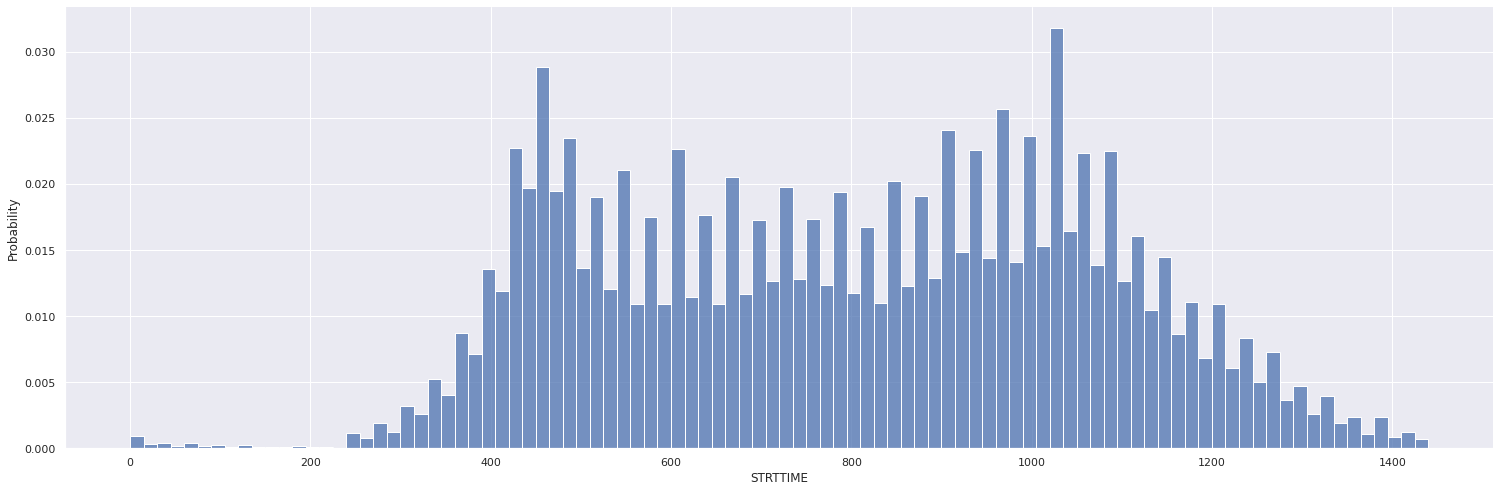

In [35]:
sns.displot(df_tmp, x="STRTTIME", stat="probability",bins=list(range(0,1441, tau)), height = 7, aspect = 3)

In [77]:
hist_strtttime = np.histogram(df_tmp["STRTTIME"], bins = list(range(0,1441, tau)), density = True)
d_strttime = pd.DataFrame(data = {"t": hist_strtttime[1][0:int(1441/tau)], "p(t)": hist_strtttime[0]*tau})
d_strttime[d_strttime["t"] < 450].tail(4)

,t,p(t)
4,240,0.005069
5,300,0.015048
6,360,0.041312
7,420,0.090752


In [40]:
d_strttime.to_pickle("/usr/app/data/probabilities/trpstrt.pkl") 

In [55]:
# TRPMILES for each STRTIIME for deriving probability of Triplengt
df_tmp["TRPMILES"].describe()

count    423319.000000
mean          9.447009
std          25.314659
min           0.000000
25%           1.981000
50%           4.380000
75%          10.017000
max        2926.713000
Name: TRPMILES, dtype: float64

In [104]:
k = 5
bins = list(range(0,40,k))  

#range(0, int(max(df_tmp["TRPMILES"])), int(max(df_tmp["TRPMILES"])/k))
d_len = pd.DataFrame(columns=["strttime"]+bins[:-1])

for t in d_strttime["t"]:
    hist_len = np.histogram(df_tmp.loc[df_tmp.STRTTIME==t, "TRPMILES"], bins = bins, density = True)
    d_len.loc[t,:] = [t]+list(hist_len[0]*k)
    
d_len

,strttime,0,5,10,15,20,25,30
0,0,0.409266,0.200772,0.158301,0.108108,0.0501931,0.0579151,0.015444
60,60,0.351351,0.252252,0.153153,0.126126,0.027027,0.0720721,0.018018
120,120,0.287356,0.195402,0.126437,0.149425,0.172414,0.0574713,0.0114943
180,180,0.291667,0.270833,0.166667,0.104167,0.0625,0.0416667,0.0625
240,240,0.2,0.163636,0.163636,0.127273,0.127273,0.136364,0.0818182
300,300,0.207843,0.180392,0.160784,0.146405,0.132026,0.0980392,0.0745098
360,360,0.283984,0.190668,0.144908,0.139524,0.104083,0.0794078,0.0574249
420,420,0.384802,0.223114,0.148058,0.103809,0.0744959,0.0399552,0.0257655
480,480,0.504898,0.216337,0.118546,0.0790304,0.0410095,0.0239084,0.016271
540,540,0.547873,0.21776,0.114218,0.0538892,0.0337231,0.0186409,0.0138959


    strttime variable     value
0          0        0  0.409266
1         60        0  0.351351
2        120        0  0.287356
3        180        0  0.291667
4        240        0  0.200000
..       ...      ...       ...
163     1140       30  0.014104
164     1200       30  0.011019
165     1260       30  0.014310
166     1320       30  0.027356
167     1380       30  0.031199

[168 rows x 3 columns]


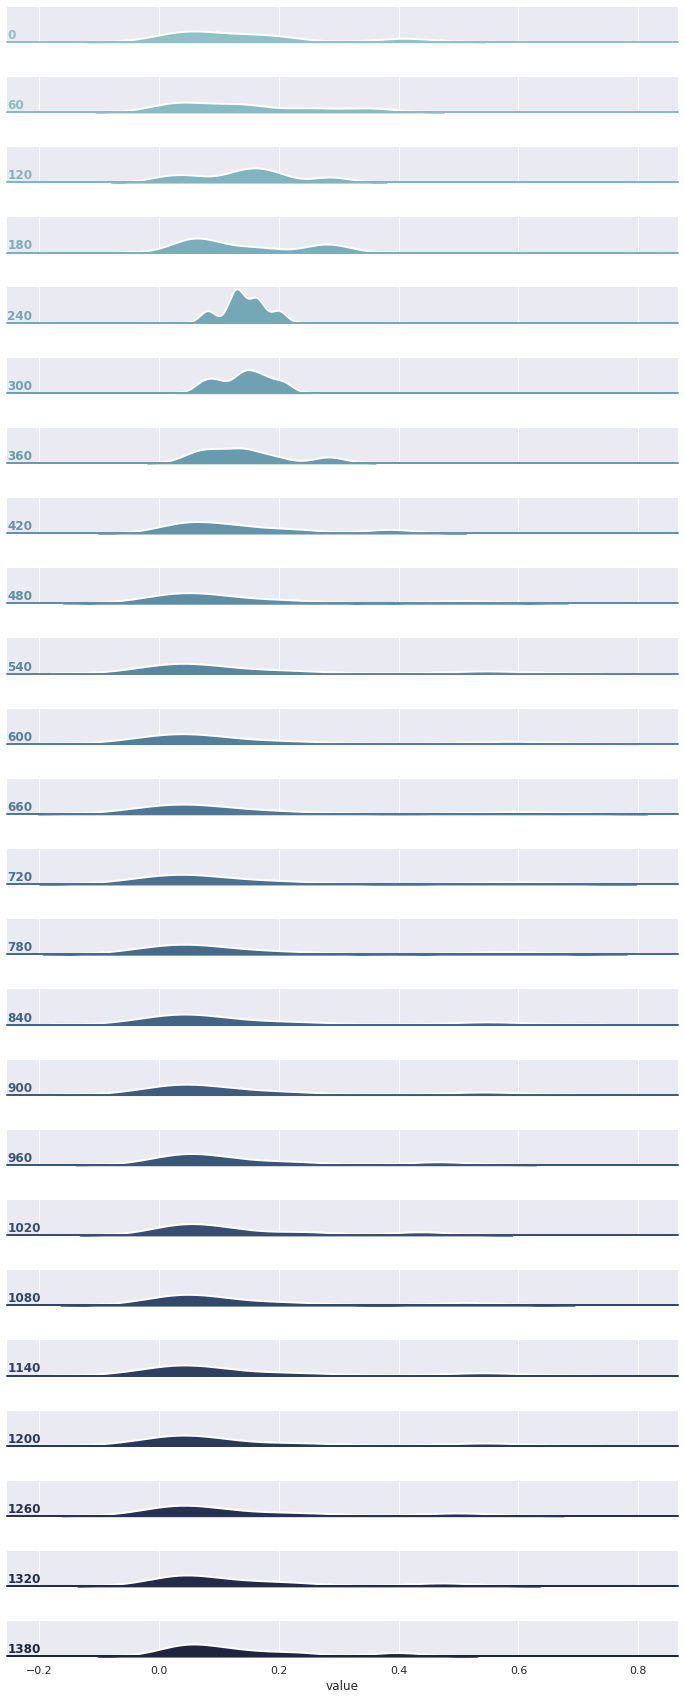

In [110]:
df_plot = pd.melt(d_len, id_vars="strttime")
df_plot["value"] = df_plot["value"].astype("float")
print(df_plot)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(24, rot=-.25, light=.7)
g = sns.FacetGrid(df_plot, row="strttime", hue="strttime", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")

# Set the subplots to overlap
#g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

<AxesSubplot:xlabel='variable', ylabel='strttime'>

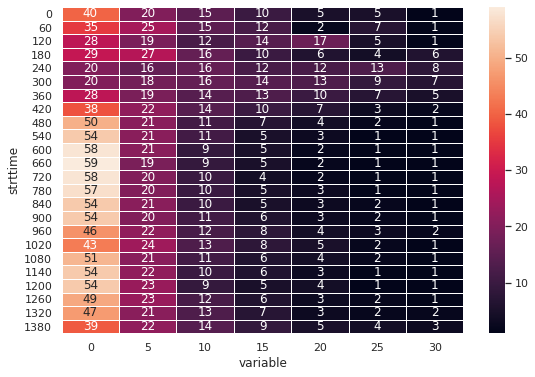

In [111]:
df_plot["value"] = df_plot["value"]*100
df_plot["value"] = df_plot["value"].astype("int32")
df_plot = df_plot.pivot("strttime", "variable", "value")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_plot, annot=True, fmt="d", linewidths=.5, ax=ax)